In [56]:
# ---------------------------------------------------------------------------
# Langkah 0: Instalasi Pustaka yang Diperlukan
# ---------------------------------------------------------------------------
import subprocess
import sys

def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

required_packages = [
    'pandas',
    'numpy', 
    'scikit-learn',
    'matplotlib',
    'seaborn'
]

for package in required_packages:
    try:
        __import__(package.replace('-', '_'))
    except ImportError:
        install(package)


In [57]:
# ---------------------------------------------------------------------------
# Langkah 1: Impor Pustaka yang Diperlukan
# ---------------------------------------------------------------------------
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [66]:
# ---------------------------------------------------------------------------
# Langkah 2: Memuat Dataset dari File CSV Lokal
# ---------------------------------------------------------------------------

# Path ke file CSV lokal
file_path = '../model/data/dummydata_kpbu_with_token.csv'

# Muat data dari file CSV
try:
    df = pd.read_csv(file_path)
    print(f"File '{file_path}' berhasil dimuat.")
except FileNotFoundError:
    print(f"File tidak ditemukan: {file_path}")
    print("Pastikan file dummydata_kpbu.csv ada di folder data/")
    raise SystemExit()
except Exception as e:
    print(f"Terjadi kesalahan saat memuat file: {e}")
    raise SystemExit()

print("\n--- Data Awal Proyek (dari CSV) ---")
print(df.head())
print("\nDistribusi Profil Risiko dalam Dataset:")
print(df['Profil_Risiko'].value_counts())
print("\nInfo Tipe Data:")
df.info()

File '../model/data/dummydata_kpbu_with_token.csv' berhasil dimuat.

--- Data Awal Proyek (dari CSV) ---
  ID_Proyek                            Nama_Proyek  id_sektor  id_status  \
0   PROJ101               Jalan Tol Pandaan-Malang          3          7   
1   PROJ102              Jalan Tol Batang-Semarang          3          7   
2   PROJ103  Optimalisasi Saluran Irigasi Komering          1          2   
3   PROJ104                        Bendungan Bodri          1          2   
4   PROJ105         Optimalisasi HLD Sungai Lombok          1          2   

   Durasi_Konsesi_Tahun  Nilai_Investasi_Total_IDR  \
0                    35              6359000000000   
1                    38             13968000000000   
2                    22              1733000000000   
3                    25              1744000000000   
4                    28              1578000000000   

   Target_Dana_Tokenisasi_IDR  Persentase_Tokenisasi Jenis_Token_Utama  \
0               1907700000000          

In [67]:
# ---------------------------------------------------------------------------
# Langkah 2.5: Memuat Data Referensi Risiko Sektor
# ---------------------------------------------------------------------------

# Path ke file referensi sektor
ref_sektor_path = '../model/data/ref_sektor.csv'

try:
    df_sektor = pd.read_csv(ref_sektor_path)
    print(f"File referensi sektor '{ref_sektor_path}' berhasil dimuat.")
    print("\n--- Data Referensi Risiko Sektor ---")
    print(df_sektor.head())
    print(f"\nJumlah sektor: {len(df_sektor)}")
    
    # Menggabungkan data proyek dengan data risiko sektor
    df = df.merge(df_sektor[['id_sektor', 'risk_rank']], on='id_sektor', how='left')
    
    print("\n--- Data Proyek Setelah Penambahan Risk Rank ---")
    print(df[['ID_Proyek', 'Nama_Proyek', 'id_sektor', 'risk_rank', 'Profil_Risiko']].head())
    
    # Periksa apakah ada sektor yang tidak memiliki risk_rank
    missing_risk = df[df['risk_rank'].isna()]
    if len(missing_risk) > 0:
        print(f"\nPeringatan: {len(missing_risk)} proyek tidak memiliki risk_rank:")
        print(missing_risk[['ID_Proyek', 'id_sektor']].head())
    else:
        print("\nSemua proyek berhasil mendapatkan risk_rank dari sektor.")
        
except FileNotFoundError:
    print(f"File referensi sektor tidak ditemukan: {ref_sektor_path}")
    print("Model akan berjalan tanpa fitur risk_rank sektor")
    df['risk_rank'] = None
except Exception as e:
    print(f"Terjadi kesalahan saat memuat referensi sektor: {e}")
    df['risk_rank'] = None

File referensi sektor '../model/data/ref_sektor.csv' berhasil dimuat.

--- Data Referensi Risiko Sektor ---
                                         sektor_name  id_sektor  risk_rank
0                                          Air minum          1          5
1  Bangunan negara antara lain gedung perkantoran...          9         11
2  Fasilitas pendidikan, penelitian dan pengembangan          6         13
3                                Fasilitas perkotaan         17         10
4     Fasilitas sarana olahraga, kesenian dan budaya         20         10

Jumlah sektor: 21

--- Data Proyek Setelah Penambahan Risk Rank ---
  ID_Proyek                            Nama_Proyek  id_sektor  risk_rank  \
0   PROJ101               Jalan Tol Pandaan-Malang          3          2   
1   PROJ102              Jalan Tol Batang-Semarang          3          2   
2   PROJ103  Optimalisasi Saluran Irigasi Komering          1          5   
3   PROJ104                        Bendungan Bodri          1        

In [68]:
# ---------------------------------------------------------------------------
# Langkah 3: Pra-pemrosesan Data (Data Preprocessing)
# ---------------------------------------------------------------------------
# Memisahkan fitur (X) dan target (y)
X = df.drop(['ID_Proyek', 'Nama_Proyek', 'Profil_Risiko'], axis=1)
y = df['Profil_Risiko']

print("--- Struktur Data Sebelum Preprocessing ---")
print(f"Kolom yang tersedia: {list(X.columns)}")
print(f"Shape data: {X.shape}")
print("\nContoh data:")
print(X.head())

# Buat fitur tambahan berbasis risiko sektor
if 'risk_rank' in X.columns and X['risk_rank'].notna().any():
    # Inversi risk_rank agar nilai tinggi = risiko tinggi (karena 1 = risiko tertinggi)
    X['sektor_risk_score'] = 15 - X['risk_rank']  # Inversi skala (1->14, 14->1)
    
    # Buat kategori risiko sektor
    X['sektor_risk_category'] = pd.cut(X['risk_rank'], 
                                      bins=[0, 3, 7, 11, 15], 
                                      labels=['Sangat_Tinggi', 'Tinggi', 'Menengah', 'Rendah'])
    
    print("--- Analisis Risiko Sektor ---")
    print("Distribusi kategori risiko sektor:")
    print(X['sektor_risk_category'].value_counts())
    print("\nKorelasi risk_rank dengan profil risiko aktual:")
    risk_correlation = df.groupby('Profil_Risiko')['risk_rank'].mean().sort_values()
    print(risk_correlation)
else:
    print("Risk rank tidak tersedia atau kosong")

# Identifikasi kolom kategorikal yang ada dalam dataset
categorical_columns = []

# Periksa kolom-kolom kategorikal yang mungkin ada
possible_categorical_columns = ['Jenis_Token_Utama', 'sektor_risk_category']

for col in possible_categorical_columns:
    if col in X.columns:
        categorical_columns.append(col)
        print(f"Kolom kategorikal ditemukan: {col}")
        print(f"Nilai unik dalam {col}: {X[col].unique()}")
    else:
        print(f"Kolom kategorikal tidak ditemukan: {col}")

# Lakukan One-Hot Encoding hanya untuk kolom yang ada
if categorical_columns:
    print(f"\nMelakukan One-Hot Encoding untuk kolom: {categorical_columns}")
    X = pd.get_dummies(X, columns=categorical_columns, drop_first=True)
else:
    print("\nTidak ada kolom kategorikal untuk di-encode")

# Inisialisasi scaler untuk normalisasi fitur (penting untuk LogisticRegression)
scaler = StandardScaler()

# Mengubah label target menjadi numerik
le = LabelEncoder()
y_encoded = le.fit_transform(y)
risk_mapping = {index: label for index, label in enumerate(le.classes_)}
print(f"\n--- Pemetaan Label Risiko ---\n{risk_mapping}\n")

print("--- Data Setelah Pra-pemrosesan (Siap untuk Model) ---")
print(X.head())
print(f"\nJumlah fitur setelah preprocessing: {X.shape[1]}")
print(f"Nama kolom: {list(X.columns)}")

# Tampilkan fitur-fitur baru yang berkaitan dengan risiko
risk_features = [col for col in X.columns if 'risk' in col.lower() or 'sektor' in col.lower()]
if risk_features:
    print(f"\nFitur terkait risiko sektor: {risk_features}")

# Tampilkan tipe data untuk memastikan semua numerik
print(f"\nTipe data setelah preprocessing:")
print(X.dtypes)


--- Struktur Data Sebelum Preprocessing ---
Kolom yang tersedia: ['id_sektor', 'id_status', 'Durasi_Konsesi_Tahun', 'Nilai_Investasi_Total_IDR', 'Target_Dana_Tokenisasi_IDR', 'Persentase_Tokenisasi', 'Jenis_Token_Utama', 'Token_Risk_Level_Ordinal', 'Token_Ada_Jaminan_Pokok', 'Token_Return_Berbasis_Kinerja', 'Dok_Studi_Kelayakan', 'Dok_Laporan_Keuangan_Audit', 'Dok_Peringkat_Kredit', 'risk_rank']
Shape data: (57, 14)

Contoh data:
   id_sektor  id_status  Durasi_Konsesi_Tahun  Nilai_Investasi_Total_IDR  \
0          3          7                    35              6359000000000   
1          3          7                    38             13968000000000   
2          1          2                    22              1733000000000   
3          1          2                    25              1744000000000   
4          1          2                    28              1578000000000   

   Target_Dana_Tokenisasi_IDR  Persentase_Tokenisasi Jenis_Token_Utama  \
0               1907700000000      

In [69]:
# ---------------------------------------------------------------------------
# Langkah 4: Membagi Data dan Melatih Model
# ---------------------------------------------------------------------------
# Membagi data menjadi 80% untuk latihan (training) dan 20% untuk pengujian (testing)
# 'random_state' digunakan agar hasil pembagian data selalu sama setiap kali kode dijalankan
# Menghapus 'stratify' karena ukuran data terlalu kecil dan ada kelas dengan hanya 1 sampel
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Normalisasi fitur untuk LogisticRegression
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Memilih dan menginisialisasi model
# LogisticRegression adalah pilihan yang baik untuk klasifikasi dengan interpretasi yang mudah
# max_iter ditingkatkan untuk memastikan konvergensi pada dataset kecil
model = LogisticRegression(random_state=42, max_iter=1000, solver='liblinear')

# Melatih model menggunakan data training yang sudah dinormalisasi
model.fit(X_train_scaled, y_train)
print("\n--- Model LogisticRegression Berhasil Dilatih! ---")


--- Model LogisticRegression Berhasil Dilatih! ---


/Users/ridwanfirmansyah/Documents/GitHub/model-kpbu/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(



--- Hasil Evaluasi Model LogisticRegression ---
Akurasi Model: 0.92

Laporan Klasifikasi:
              precision    recall  f1-score   support

    Menengah       1.00      0.83      0.91         6
      Rendah       1.00      1.00      1.00         4
      Tinggi       0.67      1.00      0.80         2

    accuracy                           0.92        12
   macro avg       0.89      0.94      0.90        12
weighted avg       0.94      0.92      0.92        12



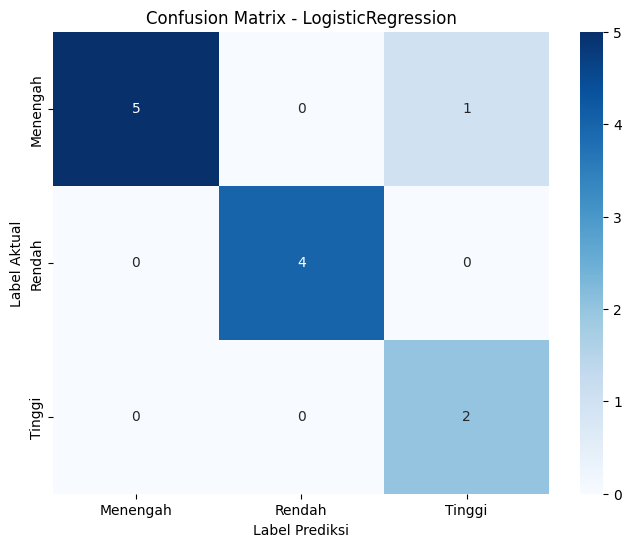

In [70]:
# ---------------------------------------------------------------------------
# Langkah 5: Evaluasi Kinerja Model
# ---------------------------------------------------------------------------
# Membuat prediksi pada data pengujian yang sudah dinormalisasi
y_pred = model.predict(X_test_scaled)

# Menampilkan hasil evaluasi
print("\n--- Hasil Evaluasi Model LogisticRegression ---")
print(f"Akurasi Model: {accuracy_score(y_test, y_pred):.2f}")
print("\nLaporan Klasifikasi:")
# Menggunakan 'target_names' untuk menampilkan label asli
# Menambahkan parameter 'labels' untuk mengatasi ketidakcocokan jumlah kelas
print(classification_report(y_test, y_pred, target_names=le.classes_, labels=le.transform(le.classes_), zero_division=0))

# Menampilkan Confusion Matrix untuk melihat kesalahan prediksi secara detail
cm = confusion_matrix(y_test, y_pred, labels=le.transform(le.classes_)) # Menambahkan parameter 'labels' di sini juga
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix - LogisticRegression')
plt.ylabel('Label Aktual')
plt.xlabel('Label Prediksi')
plt.show()

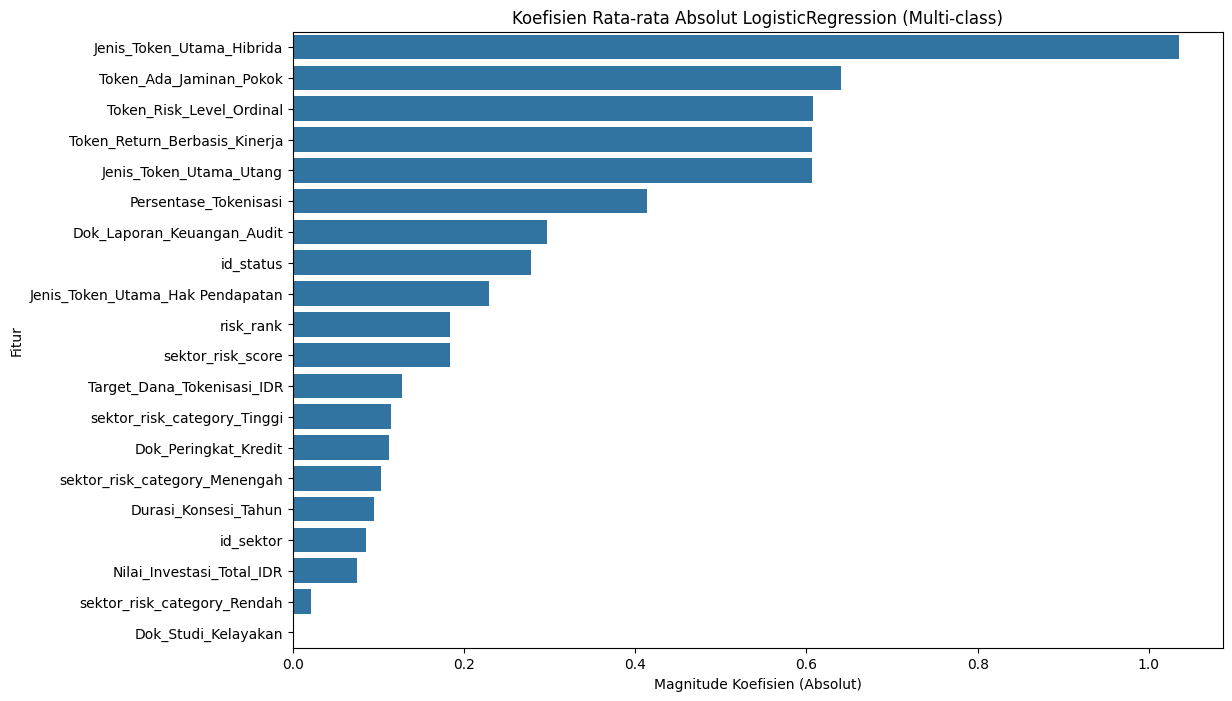


--- Koefisien Model LogisticRegression ---
(Nilai absolut yang lebih besar menunjukkan pengaruh yang lebih kuat)
Jenis_Token_Utama_Hibrida           1.034818
Token_Ada_Jaminan_Pokok             0.640086
Token_Risk_Level_Ordinal            0.607323
Token_Return_Berbasis_Kinerja       0.606552
Jenis_Token_Utama_Utang             0.606552
Persentase_Tokenisasi               0.413839
Dok_Laporan_Keuangan_Audit          0.297447
id_status                           0.278292
Jenis_Token_Utama_Hak Pendapatan    0.229071
risk_rank                           0.183656
sektor_risk_score                   0.183656
Target_Dana_Tokenisasi_IDR          0.127378
sektor_risk_category_Tinggi         0.114719
Dok_Peringkat_Kredit                0.112188
sektor_risk_category_Menengah       0.103330
Durasi_Konsesi_Tahun                0.095002
id_sektor                           0.085129
Nilai_Investasi_Total_IDR           0.074582
sektor_risk_category_Rendah         0.020799
Dok_Studi_Kelayakan            

In [71]:
# ---------------------------------------------------------------------------
# Langkah 6: Menganalisis Koefisien Model (Feature Coefficients)
# ---------------------------------------------------------------------------
# Menganalisis koefisien LogisticRegression untuk memahami pengaruh fitur
# Nilai koefisien positif meningkatkan probabilitas kelas, negatif menurunkannya

# Untuk multi-class classification, ambil koefisien absolut rata-rata
if len(le.classes_) > 2:
    # Multi-class: ambil rata-rata absolut koefisien untuk semua kelas
    feature_coefficients = pd.Series(
        np.mean(np.abs(model.coef_), axis=0), 
        index=X.columns
    ).sort_values(ascending=False)
    title = 'Koefisien Rata-rata Absolut LogisticRegression (Multi-class)'
else:
    # Binary classification: gunakan koefisien langsung
    feature_coefficients = pd.Series(
        np.abs(model.coef_[0]), 
        index=X.columns
    ).sort_values(ascending=False)
    title = 'Koefisien Absolut LogisticRegression (Binary)'

plt.figure(figsize=(12, 8))
sns.barplot(x=feature_coefficients, y=feature_coefficients.index)
plt.title(title)
plt.xlabel('Magnitude Koefisien (Absolut)')
plt.ylabel('Fitur')
plt.show()

print(f"\n--- Koefisien Model LogisticRegression ---")
print("(Nilai absolut yang lebih besar menunjukkan pengaruh yang lebih kuat)")
print(feature_coefficients)




--- ANALISIS PENGARUH RISK RANK SEKTOR ---
Statistik Risk Rank per Profil Risiko:
              risk_rank                   
                   mean median   std count
Profil_Risiko                             
Menengah           6.36    5.0  4.38    25
Rendah             2.50    2.0  1.73    12
Tinggi             4.95    5.0  3.65    20


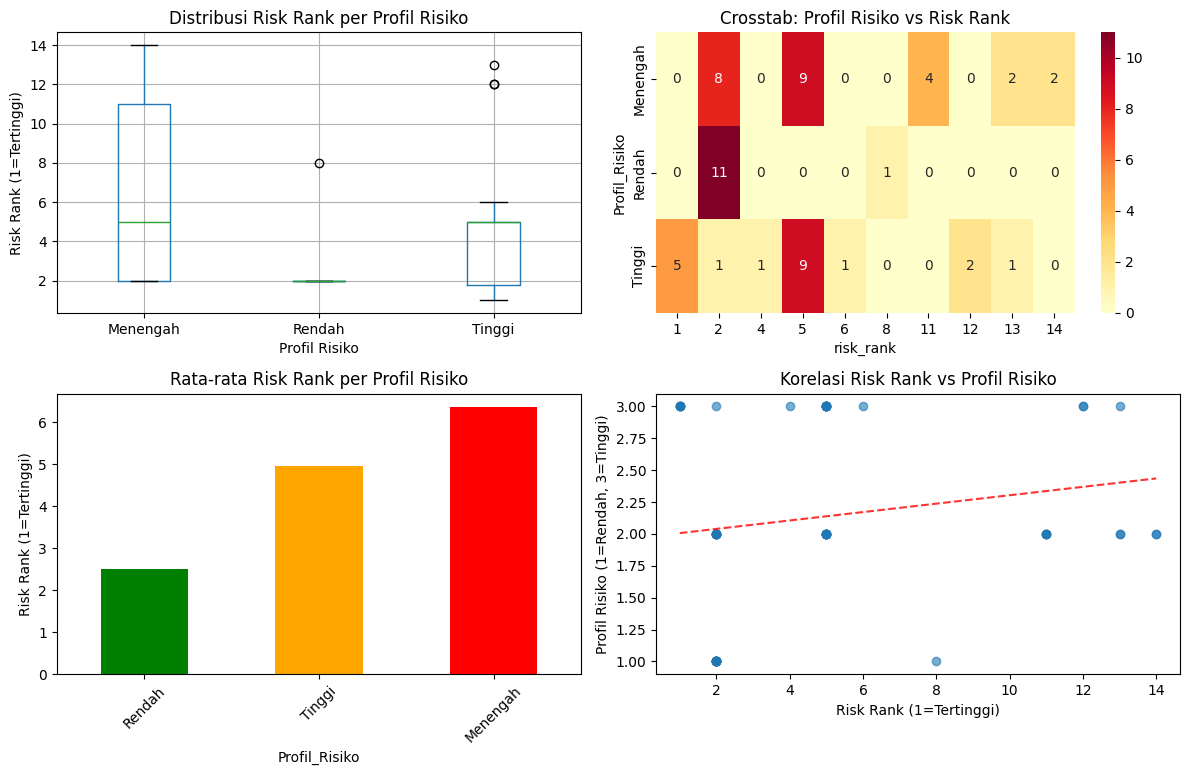


--- SEKTOR DENGAN RISIKO TERTINGGI (Risk Rank 1-3) ---
                                          sektor_name  id_sektor  risk_rank
11  Minyak dan gas bumi dan energi terbarukan term...         16          1
6                                               Jalan          3          2
20                                       Transportasi          8          2
19                     Telekomunikasi dan informatika          7          3

Jumlah proyek dalam sektor berisiko tinggi: 25
Distribusi profil risiko proyek dalam sektor berisiko tinggi:
Profil_Risiko
Rendah      11
Menengah     8
Tinggi       6
Name: count, dtype: int64


In [72]:
# ---------------------------------------------------------------------------
# Langkah 6.5: Analisis Pengaruh Risk Rank Sektor terhadap Profil Risiko
# ---------------------------------------------------------------------------

if 'risk_rank' in df.columns and df['risk_rank'].notna().any():
    print("\n--- ANALISIS PENGARUH RISK RANK SEKTOR ---")
    
    # Analisis korelasi risk_rank dengan profil risiko
    risk_analysis = df.groupby('Profil_Risiko').agg({
        'risk_rank': ['mean', 'median', 'std', 'count']
    }).round(2)
    
    print("Statistik Risk Rank per Profil Risiko:")
    print(risk_analysis)
    
    # Visualisasi distribusi risk_rank per profil risiko
    plt.figure(figsize=(12, 8))
    
    # Subplot 1: Box plot
    plt.subplot(2, 2, 1)
    df.boxplot(column='risk_rank', by='Profil_Risiko', ax=plt.gca())
    plt.title('Distribusi Risk Rank per Profil Risiko')
    plt.xlabel('Profil Risiko')
    plt.ylabel('Risk Rank (1=Tertinggi)')
    plt.suptitle('')
    
    # Subplot 2: Heatmap crosstab
    plt.subplot(2, 2, 2)
    crosstab = pd.crosstab(df['Profil_Risiko'], df['risk_rank'])
    sns.heatmap(crosstab, annot=True, fmt='d', cmap='YlOrRd')
    plt.title('Crosstab: Profil Risiko vs Risk Rank')
    
    # Subplot 3: Bar plot rata-rata risk rank
    plt.subplot(2, 2, 3)
    avg_risk = df.groupby('Profil_Risiko')['risk_rank'].mean().sort_values()
    avg_risk.plot(kind='bar', color=['green', 'orange', 'red'])
    plt.title('Rata-rata Risk Rank per Profil Risiko')
    plt.ylabel('Risk Rank (1=Tertinggi)')
    plt.xticks(rotation=45)
    
    # Subplot 4: Scatter plot dengan trend line
    plt.subplot(2, 2, 4)
    # Convert categorical to numeric for scatter plot
    risk_numeric = df['Profil_Risiko'].map({'Rendah': 1, 'Menengah': 2, 'Tinggi': 3})
    plt.scatter(df['risk_rank'], risk_numeric, alpha=0.6)
    
    # Add trend line
    z = np.polyfit(df['risk_rank'].dropna(), risk_numeric.dropna(), 1)
    p = np.poly1d(z)
    plt.plot(df['risk_rank'].dropna().sort_values(), p(df['risk_rank'].dropna().sort_values()), "r--", alpha=0.8)
    
    plt.xlabel('Risk Rank (1=Tertinggi)')
    plt.ylabel('Profil Risiko (1=Rendah, 3=Tinggi)')
    plt.title('Korelasi Risk Rank vs Profil Risiko')
    
    plt.tight_layout()
    plt.show()
    
    # Analisis sektor dengan risiko tertinggi
    print("\n--- SEKTOR DENGAN RISIKO TERTINGGI (Risk Rank 1-3) ---")
    high_risk_sectors = df_sektor[df_sektor['risk_rank'] <= 3].sort_values('risk_rank')
    print(high_risk_sectors)
    
    # Analisis proyek dalam sektor berisiko tinggi
    high_risk_projects = df[df['risk_rank'] <= 3]
    if len(high_risk_projects) > 0:
        print(f"\nJumlah proyek dalam sektor berisiko tinggi: {len(high_risk_projects)}")
        print("Distribusi profil risiko proyek dalam sektor berisiko tinggi:")
        print(high_risk_projects['Profil_Risiko'].value_counts())
    
else:
    print("Risk rank tidak tersedia untuk analisis")

In [74]:
# ---------------------------------------------------------------------------
# Langkah 7: Menggunakan Model untuk Memprediksi BATCH Proyek Baru dari File
# ---------------------------------------------------------------------------
print("\n\n--- TAHAP 2: PREDIKSI BATCH ---")

# Path ke file prediksi (bisa disesuaikan dengan kebutuhan)
pred_file_path = '../model/data/dataprediksi_kpbu.csv'

try:
    # Cek apakah file prediksi ada
    if os.path.exists(pred_file_path):
        df_prediksi = pd.read_csv(pred_file_path)
        print(f"File Prediksi '{pred_file_path}' berhasil dimuat.")
        
        # Periksa dan standarisasi nama kolom
        # File prediksi menggunakan nama yang berbeda dari file training
        if 'Sektor_Proyek' in df_prediksi.columns:
            # Konversi nama sektor ke ID sektor untuk konsistensi
            sektor_mapping = {
                'Air & Sanitasi': 1, 'Energi': 2, 'Jalan & Jembatan': 3, 'Pelabuhan': 4, 
                'Bandara': 5, 'Kereta Api': 6, 'Teknologi Informasi': 9, 'Kesehatan': 13
            }
            df_prediksi['id_sektor'] = df_prediksi['Sektor_Proyek'].map(sektor_mapping)
            df_prediksi = df_prediksi.drop('Sektor_Proyek', axis=1)
            
        if 'Status_Proyek' in df_prediksi.columns:
            # Konversi nama status ke ID status untuk konsistensi
            status_mapping = {
                'Pra-Studi Kelayakan': 2, 'Studi Kelayakan': 3, 'Konstruksi': 6, 'Operasi': 7
            }
            df_prediksi['id_status'] = df_prediksi['Status_Proyek'].map(status_mapping)
            df_prediksi = df_prediksi.drop('Status_Proyek', axis=1)
        
        # Periksa tipe data sebelum merge
        print("Kolom setelah standarisasi:", list(df_prediksi.columns))
        if 'id_sektor' in df_prediksi.columns:
            print(f"Tipe data id_sektor dalam df_prediksi: {df_prediksi['id_sektor'].dtype}")
            print(f"Contoh nilai id_sektor dalam df_prediksi: {df_prediksi['id_sektor'].head().tolist()}")
        
        if 'df_sektor' in globals():
            print(f"Tipe data id_sektor dalam df_sektor: {df_sektor['id_sektor'].dtype}")
            print(f"Contoh nilai id_sektor dalam df_sektor: {df_sektor['id_sektor'].head().tolist()}")
            
        # Tambahkan risk_rank dari data referensi sektor
        if 'df_sektor' in globals() and 'id_sektor' in df_prediksi.columns:
            # Pastikan tipe data konsisten sebelum merge
            try:
                # Konversi kedua kolom ke tipe yang sama (int)
                df_prediksi['id_sektor'] = pd.to_numeric(df_prediksi['id_sektor'], errors='coerce')
                df_sektor['id_sektor'] = pd.to_numeric(df_sektor['id_sektor'], errors='coerce')
                
                # Periksa apakah ada nilai NaN setelah konversi
                if df_prediksi['id_sektor'].isna().any():
                    print("Peringatan: Ada nilai id_sektor yang tidak dapat dikonversi ke angka")
                    print("Nilai yang bermasalah:", df_prediksi[df_prediksi['id_sektor'].isna()]['id_sektor'])
                
                # Lakukan merge
                df_prediksi = df_prediksi.merge(df_sektor[['id_sektor', 'risk_rank']], on='id_sektor', how='left')
                print("Risk rank berhasil ditambahkan untuk data prediksi")
                
                # Periksa apakah ada proyek yang tidak mendapat risk_rank
                missing_risk = df_prediksi[df_prediksi['risk_rank'].isna()]
                if len(missing_risk) > 0:
                    print(f"Peringatan: {len(missing_risk)} proyek tidak mendapat risk_rank")
                    print("ID sektor yang tidak ditemukan:", missing_risk['id_sektor'].unique())
                
            except Exception as merge_error:
                print(f"Error saat melakukan merge: {merge_error}")
                print("Melanjutkan tanpa risk_rank...")
        else:
            print("Risk rank tidak dapat ditambahkan - data referensi atau id_sektor tidak tersedia")
            
    else:
        print(f"File prediksi tidak ditemukan: {pred_file_path}")
        print("Menggunakan subset data training untuk demo prediksi...")
        # Gunakan beberapa baris pertama dari data asli tanpa kolom Profil_Risiko sebagai contoh
        df_prediksi = df.drop('Profil_Risiko', axis=1).head(3)

    # Simpan ID dan Nama Proyek untuk hasil akhir
    pred_ids = df_prediksi['ID_Proyek']
    pred_names = df_prediksi['Nama_Proyek']

    # Lakukan pra-pemrosesan yang SAMA PERSIS dengan data latihan
    X_pred = df_prediksi.drop(['ID_Proyek', 'Nama_Proyek'], axis=1)
    
    print(f"Kolom data prediksi sebelum preprocessing: {list(X_pred.columns)}")
    
    # Buat fitur tambahan berbasis risiko sektor (sama dengan training)
    if 'risk_rank' in X_pred.columns and X_pred['risk_rank'].notna().any():
        # Inversi risk_rank agar nilai tinggi = risiko tinggi
        X_pred['sektor_risk_score'] = 15 - X_pred['risk_rank']
        
        # Buat kategori risiko sektor
        X_pred['sektor_risk_category'] = pd.cut(X_pred['risk_rank'], 
                                               bins=[0, 3, 7, 11, 15], 
                                               labels=['Sangat_Tinggi', 'Tinggi', 'Menengah', 'Rendah'])
    
    # Identifikasi kolom kategorikal yang ada dalam dataset prediksi
    categorical_columns = []
    possible_categorical_columns = ['Jenis_Token_Utama', 'sektor_risk_category']
    
    for col in possible_categorical_columns:
        if col in X_pred.columns:
            categorical_columns.append(col)
            print(f"Kolom kategorikal ditemukan untuk prediksi: {col}")
        else:
            print(f"Kolom kategorikal tidak ditemukan untuk prediksi: {col}")
    
    # Lakukan One-Hot Encoding hanya untuk kolom yang ada
    if categorical_columns:
        print(f"Melakukan One-Hot Encoding untuk kolom prediksi: {categorical_columns}")
        X_pred = pd.get_dummies(X_pred, columns=categorical_columns, drop_first=True)
    else:
        print("Tidak ada kolom kategorikal untuk di-encode dalam data prediksi")

    # Reindex kolom agar cocok persis dengan data training, isi kolom yang hilang dengan 0
    X_pred = X_pred.reindex(columns=X.columns, fill_value=0)
    
    print(f"Shape data prediksi setelah preprocessing: {X_pred.shape}")
    print(f"Shape data training: {X.shape}")
    
    # Normalisasi data prediksi menggunakan scaler yang sama
    X_pred_scaled = scaler.transform(X_pred)

    # Lakukan prediksi menggunakan data yang sudah dinormalisasi
    prediksi_encoded = model.predict(X_pred_scaled)
    prediksi_proba = model.predict_proba(X_pred_scaled)
    prediksi_labels = le.inverse_transform(prediksi_encoded)

    # Buat DataFrame untuk menampilkan hasil dengan rapi
    hasil_df = pd.DataFrame({
        'ID_Proyek': pred_ids,
        'Nama_Proyek': pred_names,
        'Prediksi_Profil_Risiko': prediksi_labels
    })

    # Tambahkan informasi risiko sektor jika tersedia
    if 'risk_rank' in df_prediksi.columns:
        hasil_df['Sektor_Risk_Rank'] = df_prediksi['risk_rank'].values
        hasil_df['Sektor_Risk_Level'] = df_prediksi['risk_rank'].map(
            lambda x: 'Sangat Tinggi' if x <= 3 else 
                     'Tinggi' if x <= 7 else 
                     'Menengah' if x <= 11 else 'Rendah' if pd.notna(x) else 'Unknown'
        )

    # Tambahkan probabilitas untuk setiap kelas
    for i, class_name in enumerate(le.classes_):
        hasil_df[f'Prob_{class_name}'] = [f"{p:.2%}" for p in prediksi_proba[:, i]]

    print("\n--- HASIL PREDIKSI PROFIL RISIKO UNTUK PROYEK BARU (LogisticRegression + Risk Rank) ---")
    print(hasil_df.to_string(index=False))

except Exception as e:
    print(f"\nTerjadi kesalahan saat memproses file prediksi: {e}")
    import traceback
    traceback.print_exc()



--- TAHAP 2: PREDIKSI BATCH ---
File Prediksi '../model/data/dataprediksi_kpbu.csv' berhasil dimuat.
Kolom setelah standarisasi: ['ID_Proyek', 'Nama_Proyek', 'id_sektor', 'id_status', 'Durasi_Konsesi_Tahun', 'Nilai_Investasi_Total_IDR', 'Target_Dana_Tokenisasi_IDR', 'Persentase_Tokenisasi', 'Jenis_Token_Utama', 'Token_Risk_Level_Ordinal', 'Token_Ada_Jaminan_Pokok', 'Token_Return_Berbasis_Kinerja', 'Dok_Studi_Kelayakan', 'Dok_Laporan_Keuangan_Audit', 'Dok_Peringkat_Kredit']
Tipe data id_sektor dalam df_prediksi: object
Contoh nilai id_sektor dalam df_prediksi: ['3', '4', '13', '16', '7']
Tipe data id_sektor dalam df_sektor: int64
Contoh nilai id_sektor dalam df_sektor: [1, 9, 6, 17, 20]
Peringatan: Ada nilai id_sektor yang tidak dapat dikonversi ke angka
Nilai yang bermasalah: 8   NaN
Name: id_sektor, dtype: float64
Risk rank berhasil ditambahkan untuk data prediksi
Peringatan: 1 proyek tidak mendapat risk_rank
ID sektor yang tidak ditemukan: [nan]
Kolom data prediksi sebelum preproce

Traceback (most recent call last):
  File "/var/folders/yr/wym41yvj2zx6g5_598pxlp5w0000gn/T/ipykernel_2886/993292586.py", line 126, in <module>
    prediksi_encoded = model.predict(X_pred_scaled)
  File "/Users/ridwanfirmansyah/Documents/GitHub/model-kpbu/.venv/lib/python3.13/site-packages/sklearn/linear_model/_base.py", line 375, in predict
    scores = self.decision_function(X)
  File "/Users/ridwanfirmansyah/Documents/GitHub/model-kpbu/.venv/lib/python3.13/site-packages/sklearn/linear_model/_base.py", line 352, in decision_function
    X = validate_data(self, X, accept_sparse="csr", reset=False)
  File "/Users/ridwanfirmansyah/Documents/GitHub/model-kpbu/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py", line 2954, in validate_data
    out = check_array(X, input_name="X", **check_params)
  File "/Users/ridwanfirmansyah/Documents/GitHub/model-kpbu/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py", line 1105, in check_array
    _assert_all_finite(
    ~~~~~